# 第38章: 拡散モデルの理論（ELBO導出編）

## 📋 この章で学ぶこと

この章を終えると、以下ができるようになります：

- [ ] 拡散モデルのELBOを導出できる
- [ ] $q(x_t | x_0)$ の閉形式を導出できる
- [ ] $q(x_{t-1} | x_t, x_0)$ の式を理解できる
- [ ] 簡略化された訓練目標を理解できる

## 🎯 前提知識

この章を学ぶには以下の知識が必要です：

- ✅ Notebook 34（EMアルゴリズム、ELBO）
- ✅ Notebook 37（拡散モデル基礎）
- ✅ KLダイバージェンスの計算

⏱️ **推定学習時間**: 180-240分  
📊 **難易度**: ★★★★★（最上級）  
🎓 **カテゴリ**: 理論

---

## 🌟 はじめに

前章では拡散モデルの基本的な概念を学びました。この章では、拡散モデルの**理論的な基盤**を深く掘り下げます。

### 🤔 なぜELBOを理解する必要があるか？

1. **損失関数の正当化**: なぜノイズ予測のMSEが正しい損失関数なのか
2. **モデル設計の指針**: どのような選択が理論的に正しいか
3. **改良の基盤**: DDIMなどの発展的な手法の理解に必要

### 📊 この章の流れ

1. ELBOの導出
2. $q(x_t | x_0)$ の閉形式
3. $q(x_{t-1} | x_t, x_0)$ の導出
4. 簡略化された損失関数

In [1]:
# ============================================================
# 環境設定
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

import torch
import torch.nn.functional as F

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# 日本語フォント設定
import matplotlib.font_manager as fm

def setup_japanese_font():
    japanese_fonts = [
        'Hiragino Sans', 'Hiragino Maru Gothic Pro', 'AppleGothic',
        'Yu Gothic', 'MS Gothic', 'Noto Sans CJK JP', 'IPAexGothic',
    ]
    available_fonts = set(f.name for f in fm.fontManager.ttflist)
    for font in japanese_fonts:
        if font in available_fonts:
            plt.rcParams['font.family'] = font
            plt.rcParams['axes.unicode_minus'] = False
            return font
    return None

font_used = setup_japanese_font()
if font_used:
    print(f"日本語フォント: {font_used}")

torch.manual_seed(42)
np.random.seed(42)

print("✅ ライブラリのインポート完了")

日本語フォント: Hiragino Sans
✅ ライブラリのインポート完了


---

## 1. ELBOの導出

### 🤔 目標

データ $x_0$ の対数尤度 $\log p_\theta(x_0)$ を最大化したい。しかし、これは直接計算できないので、代わりにELBO（下界）を最大化します。

### 📊 対数尤度の分解

$$\log p_\theta(x_0) = \log \int p_\theta(x_0, x_{1:T}) dx_{1:T}$$

ここで $x_{1:T} = (x_1, x_2, \ldots, x_T)$ です。

### 📊 ELBOの導出

任意の分布 $q(x_{1:T} | x_0)$ を導入して：

$$\log p_\theta(x_0) = \log \int q(x_{1:T}|x_0) \frac{p_\theta(x_0, x_{1:T})}{q(x_{1:T}|x_0)} dx_{1:T}$$

Jensenの不等式を適用：

$$\log p_\theta(x_0) \geq \mathbb{E}_{q(x_{1:T}|x_0)} \left[ \log \frac{p_\theta(x_0, x_{1:T})}{q(x_{1:T}|x_0)} \right] = \mathcal{L}_{\text{ELBO}}$$

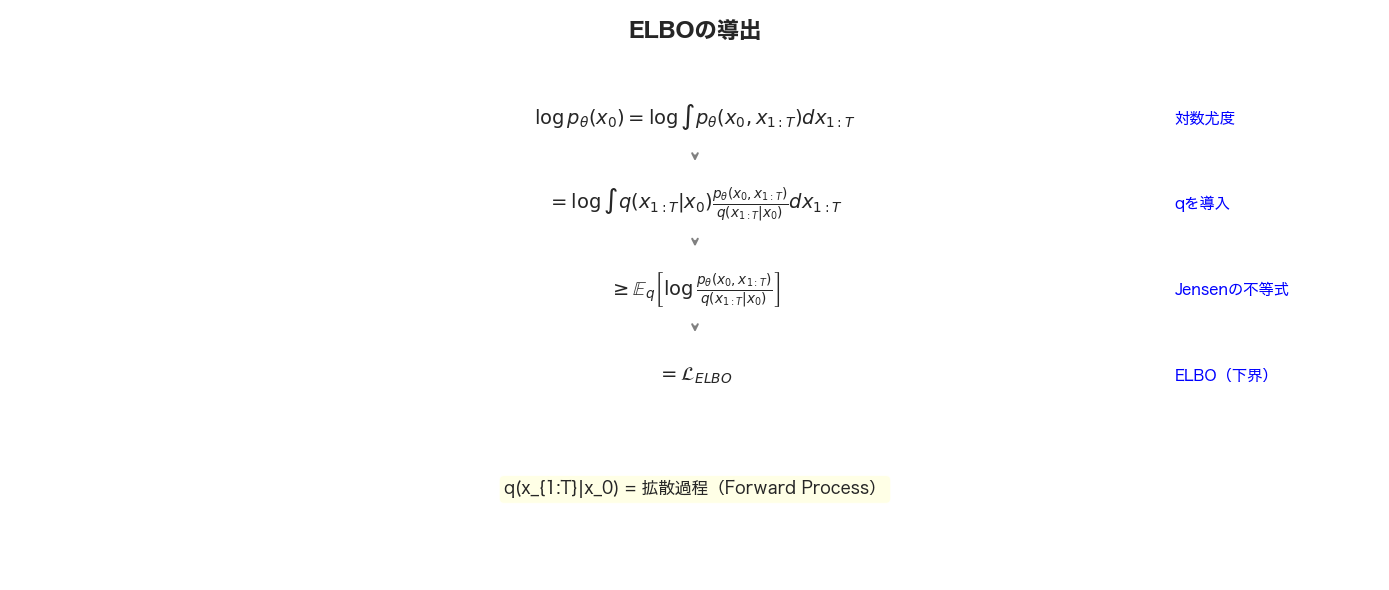

In [2]:
# ============================================================
# ELBOの構造を図示
# ============================================================

fig, ax = plt.subplots(figsize=(14, 6))

# タイトル
ax.text(0.5, 0.95, 'ELBOの導出', ha='center', fontsize=16, fontweight='bold', transform=ax.transAxes)

# 数式
equations = [
    (0.5, 0.8, r'$\log p_\theta(x_0) = \log \int p_\theta(x_0, x_{1:T}) dx_{1:T}$', '対数尤度'),
    (0.5, 0.65, r'$= \log \int q(x_{1:T}|x_0) \frac{p_\theta(x_0, x_{1:T})}{q(x_{1:T}|x_0)} dx_{1:T}$', 'qを導入'),
    (0.5, 0.5, r'$\geq \mathbb{E}_q \left[ \log \frac{p_\theta(x_0, x_{1:T})}{q(x_{1:T}|x_0)} \right]$', 'Jensenの不等式'),
    (0.5, 0.35, r'$= \mathcal{L}_{ELBO}$', 'ELBO（下界）'),
]

for x, y, eq, label in equations:
    ax.text(x, y, eq, ha='center', fontsize=14, transform=ax.transAxes)
    ax.text(0.85, y, label, ha='left', fontsize=11, color='blue', transform=ax.transAxes)

# 矢印
for i in range(len(equations) - 1):
    ax.annotate('', xy=(0.5, equations[i+1][1] + 0.08), xytext=(0.5, equations[i][1] - 0.05),
                arrowprops=dict(arrowstyle='->', color='gray', lw=1.5),
                xycoords='axes fraction', textcoords='axes fraction')

ax.text(0.5, 0.15, 'q(x_{1:T}|x_0) = 拡散過程（Forward Process）', 
        ha='center', fontsize=12, style='italic', transform=ax.transAxes,
        bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

ax.axis('off')
plt.tight_layout()
plt.show()

---

## 2. ELBOの分解

### 📊 拡散過程と逆過程の定義

**拡散過程（Forward Process）**：
$$q(x_{1:T} | x_0) = \prod_{t=1}^{T} q(x_t | x_{t-1})$$

**逆過程（Reverse Process）**：
$$p_\theta(x_{0:T}) = p(x_T) \prod_{t=1}^{T} p_\theta(x_{t-1} | x_t)$$

### 📊 ELBOの展開

$$\mathcal{L}_{\text{ELBO}} = \mathbb{E}_q \left[ \log \frac{p_\theta(x_{0:T})}{q(x_{1:T}|x_0)} \right]$$

これを展開すると：

$$\mathcal{L}_{\text{ELBO}} = \mathbb{E}_q \left[ \log p(x_T) + \sum_{t=1}^{T} \log \frac{p_\theta(x_{t-1}|x_t)}{q(x_t|x_{t-1})} \right]$$

### 📊 ELBOの3つの項への分解

さらに整理すると、ELBOは3種類の項に分解できます：

$$\mathcal{L}_{\text{ELBO}} = \underbrace{\mathbb{E}_q[\log p_\theta(x_0|x_1)]}_{L_0: \text{再構成項}} - \underbrace{D_{KL}(q(x_T|x_0) \| p(x_T))}_{L_T: \text{事前分布項}} - \sum_{t=2}^{T} \underbrace{\mathbb{E}_q[D_{KL}(q(x_{t-1}|x_t, x_0) \| p_\theta(x_{t-1}|x_t))]}_{L_{t-1}: \text{デノイジング項}}$$

各項の意味：
- **$L_0$（再構成項）**: 最初のステップでの再構成
- **$L_T$（事前分布項）**: 拡散の終点がN(0,I)に近いか（学習パラメータなし）
- **$L_{t-1}$（デノイジング項）**: 各ステップでの逆過程の品質

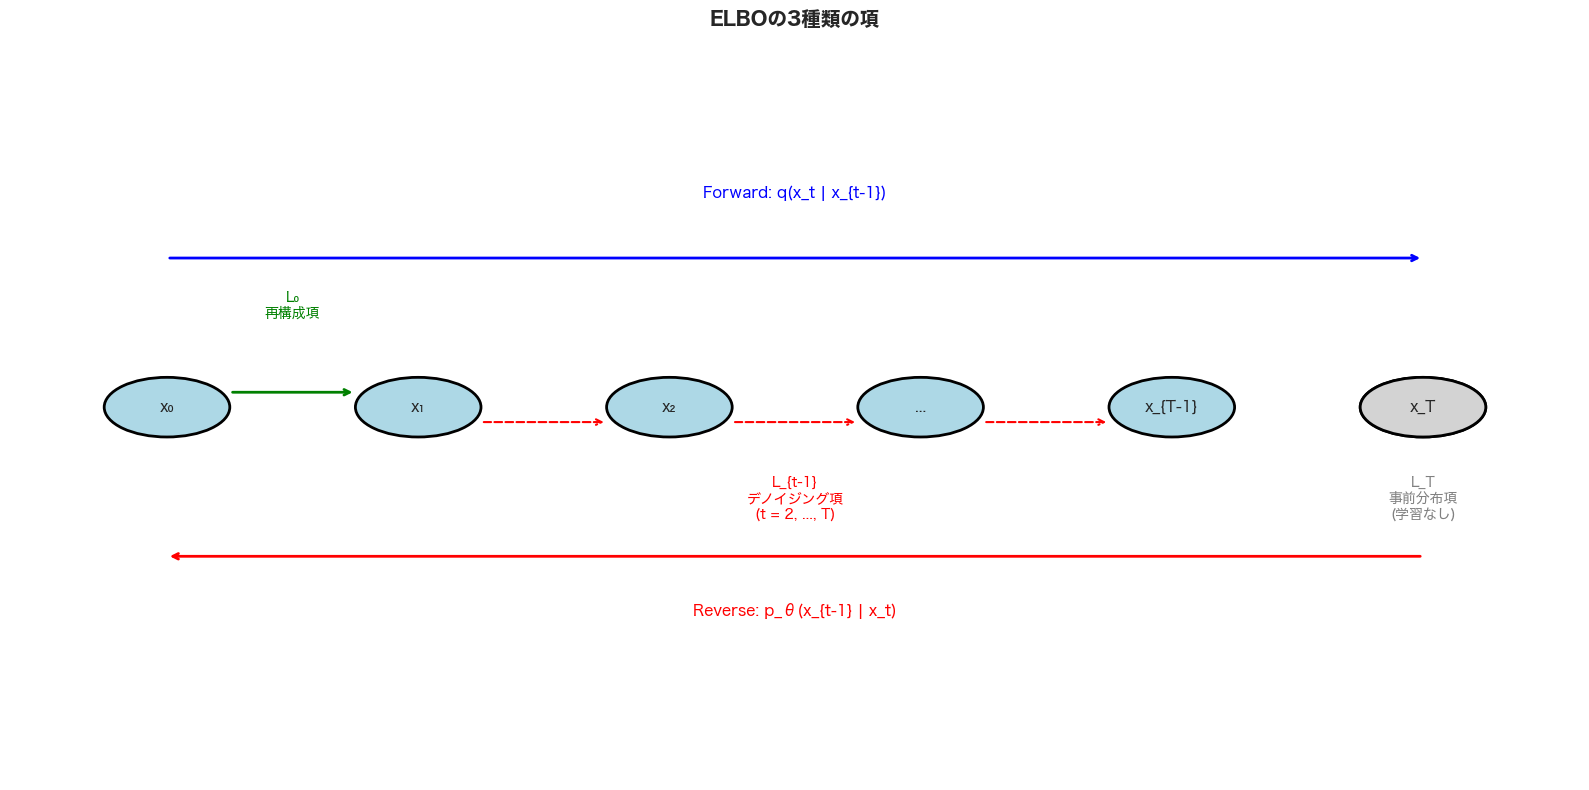

In [3]:
# ============================================================
# ELBOの各項を図示
# ============================================================

fig, ax = plt.subplots(figsize=(16, 8))

# タイムライン
positions = np.linspace(0.1, 0.9, 6)
labels = ['x₀', 'x₁', 'x₂', '...', 'x_{T-1}', 'x_T']

for pos, label in zip(positions, labels):
    circle = plt.Circle((pos, 0.5), 0.04, color='lightblue', ec='black', lw=2)
    ax.add_patch(circle)
    ax.text(pos, 0.5, label, ha='center', va='center', fontsize=11)

# 矢印と項のラベル
# L_0
ax.annotate('', xy=(positions[0] + 0.04, 0.52), xytext=(positions[1] - 0.04, 0.52),
            arrowprops=dict(arrowstyle='<-', color='green', lw=2))
ax.text((positions[0] + positions[1]) / 2, 0.62, 'L₀\n再構成項', ha='center', fontsize=10, color='green')

# L_{t-1} (デノイジング項)
for i in range(1, 4):
    ax.annotate('', xy=(positions[i] + 0.04, 0.48), xytext=(positions[i+1] - 0.04, 0.48),
                arrowprops=dict(arrowstyle='<-', color='red', lw=1.5, ls='--'))

ax.text((positions[2] + positions[3]) / 2, 0.35, 'L_{t-1}\nデノイジング項\n(t = 2, ..., T)', 
        ha='center', fontsize=10, color='red')

# L_T (事前分布項)
ax.add_patch(plt.Circle((positions[-1], 0.5), 0.04, color='lightgray', ec='black', lw=2))
ax.text(positions[-1], 0.35, 'L_T\n事前分布項\n(学習なし)', ha='center', fontsize=10, color='gray')

# Forward/Reverse
ax.annotate('', xy=(positions[-1], 0.7), xytext=(positions[0], 0.7),
            arrowprops=dict(arrowstyle='->', color='blue', lw=2))
ax.text(0.5, 0.78, 'Forward: q(x_t | x_{t-1})', ha='center', fontsize=11, color='blue')

ax.annotate('', xy=(positions[0], 0.3), xytext=(positions[-1], 0.3),
            arrowprops=dict(arrowstyle='->', color='red', lw=2))
ax.text(0.5, 0.22, 'Reverse: p_θ(x_{t-1} | x_t)', ha='center', fontsize=11, color='red')

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_title('ELBOの3種類の項', fontsize=14, fontweight='bold')
ax.axis('off')

plt.tight_layout()
plt.show()

---

## 3. $q(x_t | x_0)$ の閉形式

### 🤔 問題

拡散過程は1ステップずつ定義されていますが、訓練時には任意の $t$ で $x_t$ が必要です。

### 📊 導出

各ステップで：
$$x_t = \sqrt{1 - \beta_t} x_{t-1} + \sqrt{\beta_t} \epsilon_{t-1}$$

$\alpha_t = 1 - \beta_t$ とすると：
$$x_t = \sqrt{\alpha_t} x_{t-1} + \sqrt{1 - \alpha_t} \epsilon_{t-1}$$

これを再帰的に展開すると：

$$x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1 - \bar{\alpha}_t} \epsilon$$

ここで $\bar{\alpha}_t = \prod_{s=1}^{t} \alpha_s$ です。

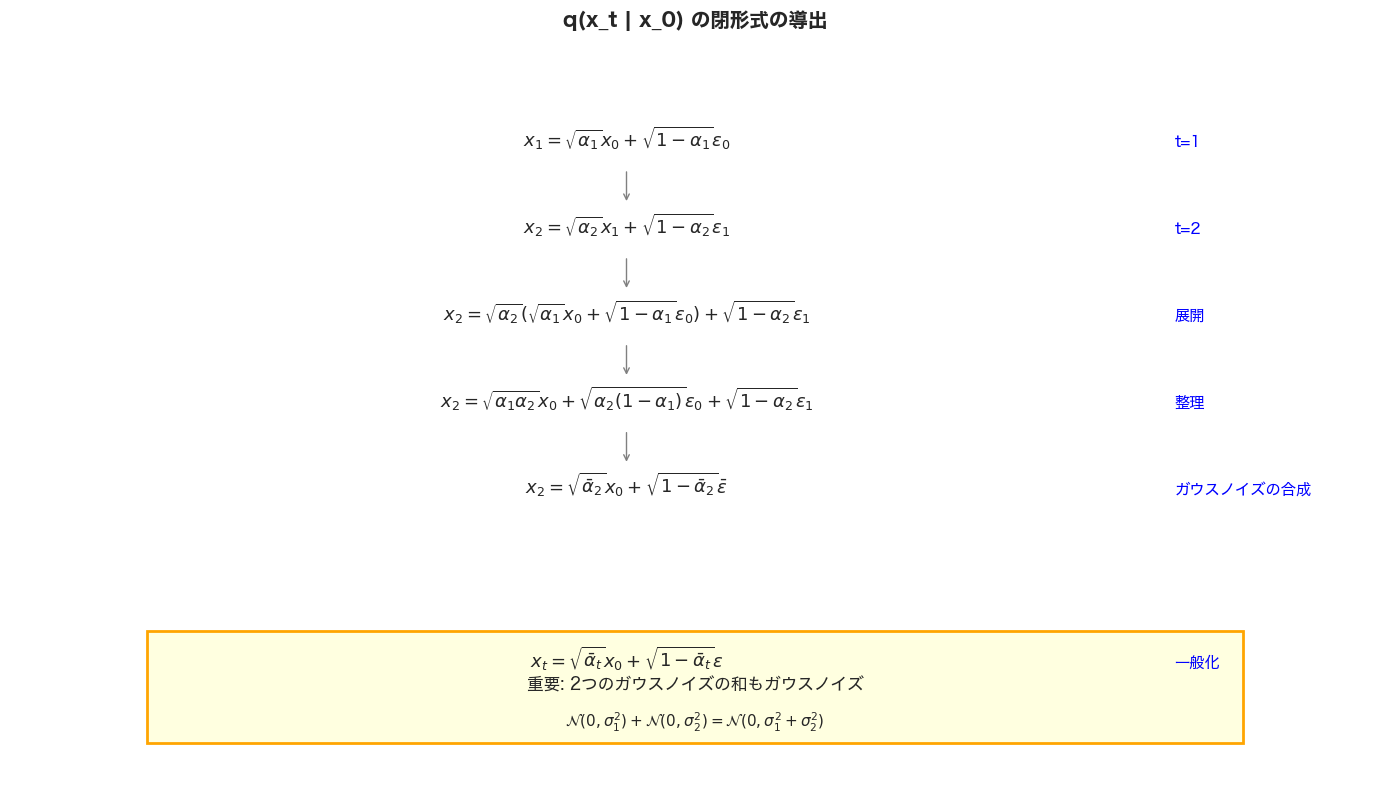

In [4]:
# ============================================================
# q(x_t | x_0) の導出を可視化
# ============================================================

fig, ax = plt.subplots(figsize=(14, 8))

derivation_steps = [
    (r'$x_1 = \sqrt{\alpha_1} x_0 + \sqrt{1-\alpha_1} \epsilon_0$', 't=1'),
    (r'$x_2 = \sqrt{\alpha_2} x_1 + \sqrt{1-\alpha_2} \epsilon_1$', 't=2'),
    (r'$x_2 = \sqrt{\alpha_2}(\sqrt{\alpha_1} x_0 + \sqrt{1-\alpha_1} \epsilon_0) + \sqrt{1-\alpha_2} \epsilon_1$', '展開'),
    (r'$x_2 = \sqrt{\alpha_1 \alpha_2} x_0 + \sqrt{\alpha_2(1-\alpha_1)} \epsilon_0 + \sqrt{1-\alpha_2} \epsilon_1$', '整理'),
    (r'$x_2 = \sqrt{\bar{\alpha}_2} x_0 + \sqrt{1-\bar{\alpha}_2} \bar{\epsilon}$', 'ガウスノイズの合成'),
    (r'', ''),
    (r'$x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1-\bar{\alpha}_t} \epsilon$', '一般化'),
]

y_positions = np.linspace(0.85, 0.15, len(derivation_steps))

for y, (eq, label) in zip(y_positions, derivation_steps):
    if eq:
        ax.text(0.45, y, eq, ha='center', fontsize=13, transform=ax.transAxes)
        ax.text(0.85, y, label, ha='left', fontsize=11, color='blue', transform=ax.transAxes)

# 矢印
for i in range(len(y_positions) - 2):
    if derivation_steps[i][0] and derivation_steps[i+1][0]:
        ax.annotate('', xy=(0.45, y_positions[i+1] + 0.04), xytext=(0.45, y_positions[i] - 0.03),
                    arrowprops=dict(arrowstyle='->', color='gray', lw=1),
                    xycoords='axes fraction', textcoords='axes fraction')

# 重要なポイント
ax.add_patch(plt.Rectangle((0.1, 0.05), 0.8, 0.15, transform=ax.transAxes,
                           facecolor='lightyellow', edgecolor='orange', lw=2))
ax.text(0.5, 0.12, '重要: 2つのガウスノイズの和もガウスノイズ', 
        ha='center', fontsize=12, transform=ax.transAxes)
ax.text(0.5, 0.07, r'$\mathcal{N}(0, \sigma_1^2) + \mathcal{N}(0, \sigma_2^2) = \mathcal{N}(0, \sigma_1^2 + \sigma_2^2)$', 
        ha='center', fontsize=11, transform=ax.transAxes)

ax.set_title('q(x_t | x_0) の閉形式の導出', fontsize=14, fontweight='bold')
ax.axis('off')

plt.tight_layout()
plt.show()

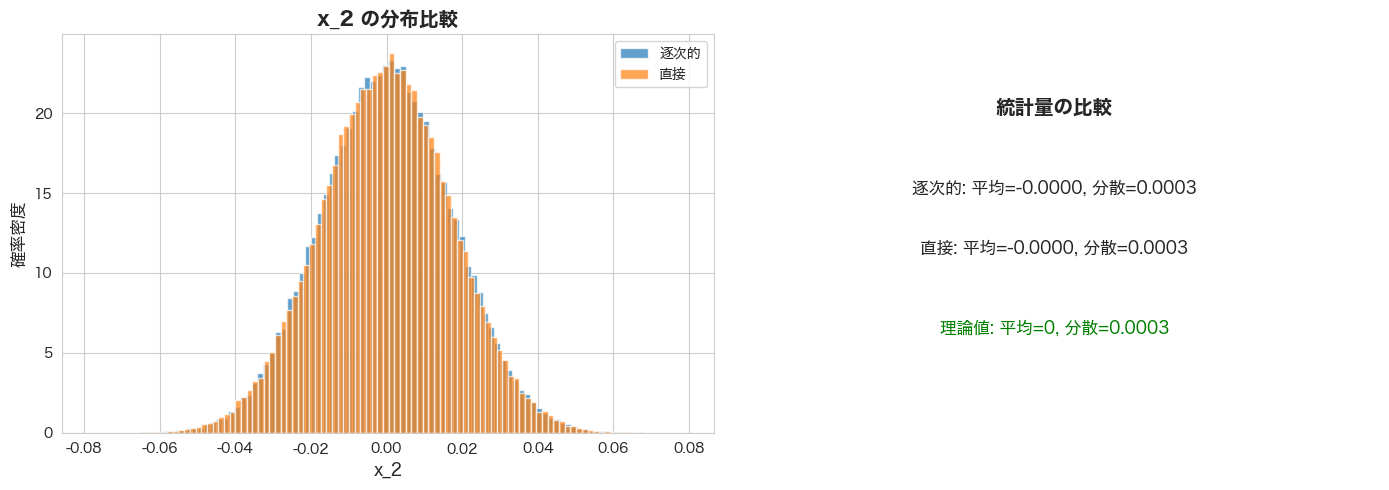

✅ 両方の方法で同じ分布が得られることを確認しました


In [5]:
# ============================================================
# ガウスノイズの合成を数値的に検証
# ============================================================

# パラメータ
alpha_1 = 0.9999
alpha_2 = 0.9998

# 方法1: 逐次的にノイズを追加
n_samples = 100000
x_0 = torch.zeros(n_samples)  # 簡単のため x_0 = 0

eps_0 = torch.randn(n_samples)
x_1 = np.sqrt(alpha_1) * x_0 + np.sqrt(1 - alpha_1) * eps_0

eps_1 = torch.randn(n_samples)
x_2_sequential = np.sqrt(alpha_2) * x_1 + np.sqrt(1 - alpha_2) * eps_1

# 方法2: 直接計算
alpha_bar_2 = alpha_1 * alpha_2
eps = torch.randn(n_samples)
x_2_direct = np.sqrt(alpha_bar_2) * x_0 + np.sqrt(1 - alpha_bar_2) * eps

# 比較
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
ax.hist(x_2_sequential.numpy(), bins=100, density=True, alpha=0.7, label='逐次的')
ax.hist(x_2_direct.numpy(), bins=100, density=True, alpha=0.7, label='直接')
ax.set_xlabel('x_2', fontsize=12)
ax.set_ylabel('確率密度', fontsize=12)
ax.set_title('x_2 の分布比較', fontsize=14, fontweight='bold')
ax.legend()

ax = axes[1]
ax.text(0.5, 0.8, '統計量の比較', ha='center', fontsize=14, fontweight='bold', transform=ax.transAxes)
ax.text(0.5, 0.6, f'逐次的: 平均={x_2_sequential.mean():.4f}, 分散={x_2_sequential.var():.4f}', 
        ha='center', fontsize=12, transform=ax.transAxes)
ax.text(0.5, 0.45, f'直接: 平均={x_2_direct.mean():.4f}, 分散={x_2_direct.var():.4f}', 
        ha='center', fontsize=12, transform=ax.transAxes)
ax.text(0.5, 0.25, f'理論値: 平均=0, 分散={1 - alpha_bar_2:.4f}', 
        ha='center', fontsize=12, color='green', transform=ax.transAxes)
ax.axis('off')

plt.tight_layout()
plt.show()

print("✅ 両方の方法で同じ分布が得られることを確認しました")

---

## 4. $q(x_{t-1} | x_t, x_0)$ の導出

### 🤔 なぜこの条件付き分布が重要か？

ELBOのデノイジング項 $L_{t-1}$ は以下の形をしています：

$$L_{t-1} = D_{KL}(q(x_{t-1}|x_t, x_0) \| p_\theta(x_{t-1}|x_t))$$

逆過程 $p_\theta$ を $q(x_{t-1}|x_t, x_0)$ に近づけることで損失を最小化します。

### 📊 ベイズの定理による導出

$$q(x_{t-1}|x_t, x_0) = \frac{q(x_t|x_{t-1}, x_0) q(x_{t-1}|x_0)}{q(x_t|x_0)}$$

マルコフ性より $q(x_t|x_{t-1}, x_0) = q(x_t|x_{t-1})$ なので：

$$q(x_{t-1}|x_t, x_0) = \frac{q(x_t|x_{t-1}) q(x_{t-1}|x_0)}{q(x_t|x_0)}$$

すべてガウス分布なので、計算すると：

$$q(x_{t-1}|x_t, x_0) = \mathcal{N}(x_{t-1}; \tilde{\mu}_t(x_t, x_0), \tilde{\beta}_t I)$$

### 📊 パラメータの式

**平均**：
$$\tilde{\mu}_t(x_t, x_0) = \frac{\sqrt{\bar{\alpha}_{t-1}} \beta_t}{1 - \bar{\alpha}_t} x_0 + \frac{\sqrt{\alpha_t}(1 - \bar{\alpha}_{t-1})}{1 - \bar{\alpha}_t} x_t$$

**分散**：
$$\tilde{\beta}_t = \frac{1 - \bar{\alpha}_{t-1}}{1 - \bar{\alpha}_t} \beta_t$$

### 📊 重要な観察

$x_0$ と $x_t$ が与えられると、$x_{t-1}$ の分布は**解析的に**決まります。
つまり、真の逆過程のターゲットは明確に定義されています。

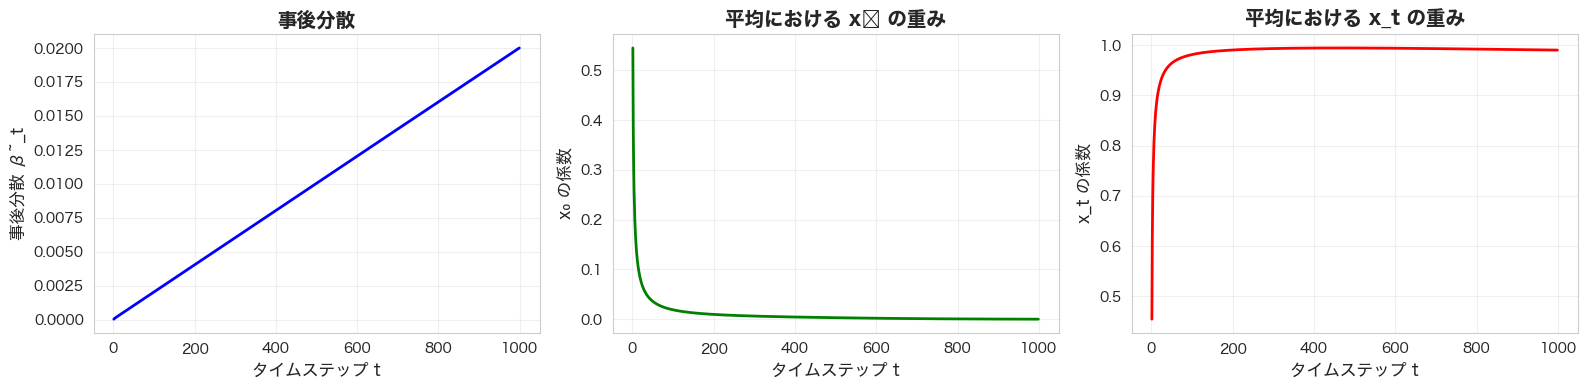

💡 観察:
  - 初期 (t=1): x₀の重み大 (0.545)、x_tの重み小 (0.455)
  - 終盤 (t=999): x₀の重み小 (0.000)、x_tの重み大 (0.990)


In [6]:
# ============================================================
# q(x_{t-1} | x_t, x_0) のパラメータを計算
# ============================================================

def get_posterior_params(betas, alpha_bars, t):
    """
    q(x_{t-1} | x_t, x_0) のパラメータを計算
    """
    alpha_t = 1 - betas[t]
    alpha_bar_t = alpha_bars[t]
    alpha_bar_t_minus_1 = alpha_bars[t-1] if t > 0 else torch.tensor(1.0)
    beta_t = betas[t]
    
    # 分散
    posterior_variance = (1 - alpha_bar_t_minus_1) / (1 - alpha_bar_t) * beta_t
    
    # 平均の係数
    coef_x0 = torch.sqrt(alpha_bar_t_minus_1) * beta_t / (1 - alpha_bar_t)
    coef_xt = torch.sqrt(alpha_t) * (1 - alpha_bar_t_minus_1) / (1 - alpha_bar_t)
    
    return posterior_variance, coef_x0, coef_xt

# ノイズスケジュール
T = 1000
betas = torch.linspace(1e-4, 0.02, T)
alphas = 1 - betas
alpha_bars = torch.cumprod(alphas, dim=0)

# 各タイムステップでのパラメータ
variances = []
coef_x0s = []
coef_xts = []

for t in range(1, T):
    var, c0, ct = get_posterior_params(betas, alpha_bars, t)
    variances.append(var.item())
    coef_x0s.append(c0.item())
    coef_xts.append(ct.item())

# 可視化
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

ax = axes[0]
ax.plot(range(1, T), variances, 'b-', linewidth=2)
ax.set_xlabel('タイムステップ t', fontsize=12)
ax.set_ylabel('事後分散 β̃_t', fontsize=12)
ax.set_title('事後分散', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

ax = axes[1]
ax.plot(range(1, T), coef_x0s, 'g-', linewidth=2)
ax.set_xlabel('タイムステップ t', fontsize=12)
ax.set_ylabel('x₀ の係数', fontsize=12)
ax.set_title('平均における x₀ の重み', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

ax = axes[2]
ax.plot(range(1, T), coef_xts, 'r-', linewidth=2)
ax.set_xlabel('タイムステップ t', fontsize=12)
ax.set_ylabel('x_t の係数', fontsize=12)
ax.set_title('平均における x_t の重み', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("💡 観察:")
print(f"  - 初期 (t=1): x₀の重み大 ({coef_x0s[0]:.3f})、x_tの重み小 ({coef_xts[0]:.3f})")
print(f"  - 終盤 (t=999): x₀の重み小 ({coef_x0s[-1]:.3f})、x_tの重み大 ({coef_xts[-1]:.3f})")

---

## 5. ノイズ予測への変換

### 🤔 $x_0$ が未知の場合

サンプリング時には $x_0$ は未知です。しかし、$x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1-\bar{\alpha}_t} \epsilon$ より：

$$x_0 = \frac{x_t - \sqrt{1-\bar{\alpha}_t} \epsilon}{\sqrt{\bar{\alpha}_t}}$$

### 📊 平均の式を書き換え

$x_0$ の代わりにノイズ $\epsilon$ を使って：

$$\tilde{\mu}_t = \frac{1}{\sqrt{\alpha_t}} \left( x_t - \frac{\beta_t}{\sqrt{1-\bar{\alpha}_t}} \epsilon \right)$$

### 📊 ニューラルネットワークの役割

ネットワーク $\epsilon_\theta(x_t, t)$ でノイズを予測し：

$$\mu_\theta(x_t, t) = \frac{1}{\sqrt{\alpha_t}} \left( x_t - \frac{\beta_t}{\sqrt{1-\bar{\alpha}_t}} \epsilon_\theta(x_t, t) \right)$$

In [7]:
# ============================================================
# ノイズ予測から平均を計算する関数
# ============================================================

def predict_mean_from_noise(x_t, t, noise_pred, betas, alpha_bars):
    """
    ノイズ予測から逆過程の平均を計算
    
    μ_θ = (1/√α_t) * (x_t - (β_t/√(1-ᾱ_t)) * ε_θ)
    """
    alpha_t = 1 - betas[t]
    alpha_bar_t = alpha_bars[t]
    beta_t = betas[t]
    
    coef = beta_t / torch.sqrt(1 - alpha_bar_t)
    mean = (1 / torch.sqrt(alpha_t)) * (x_t - coef * noise_pred)
    
    return mean

print("✅ ノイズ予測からの平均計算関数を定義しました")

# 検証
t = 500
x_0 = torch.randn(1, 28, 28)  # サンプル画像
noise_true = torch.randn_like(x_0)

# x_t を計算
alpha_bar_t = alpha_bars[t]
x_t = torch.sqrt(alpha_bar_t) * x_0 + torch.sqrt(1 - alpha_bar_t) * noise_true

# 真のノイズを使って平均を計算
mean_pred = predict_mean_from_noise(x_t, t, noise_true, betas, alpha_bars)

# 真の事後平均と比較
_, coef_x0, coef_xt = get_posterior_params(betas, alpha_bars, t)
mean_true = coef_x0 * x_0 + coef_xt * x_t

print(f"\n予測平均と真の平均の差（MSE）: {F.mse_loss(mean_pred, mean_true).item():.6f}")

✅ ノイズ予測からの平均計算関数を定義しました

予測平均と真の平均の差（MSE）: 0.000000


---

## 6. 簡略化された損失関数

### 📊 $L_{t-1}$ のKLダイバージェンス

両方の分布がガウス分布なので：

$$L_{t-1} = D_{KL}(q(x_{t-1}|x_t, x_0) \| p_\theta(x_{t-1}|x_t))$$

$$= \frac{1}{2\tilde{\beta}_t} \|\tilde{\mu}_t - \mu_\theta\|^2 + C$$

### 📊 ノイズ予測への変換

$\mu_\theta$ をノイズ予測で表すと：

$$L_{t-1} \propto \|\epsilon - \epsilon_\theta(x_t, t)\|^2$$

### 📊 最終的な損失関数（L_simple）

$$L_{\text{simple}} = \mathbb{E}_{t, x_0, \epsilon} \left[ \|\epsilon - \epsilon_\theta(\sqrt{\bar{\alpha}_t} x_0 + \sqrt{1-\bar{\alpha}_t} \epsilon, t)\|^2 \right]$$

これは単純なMSE損失です！

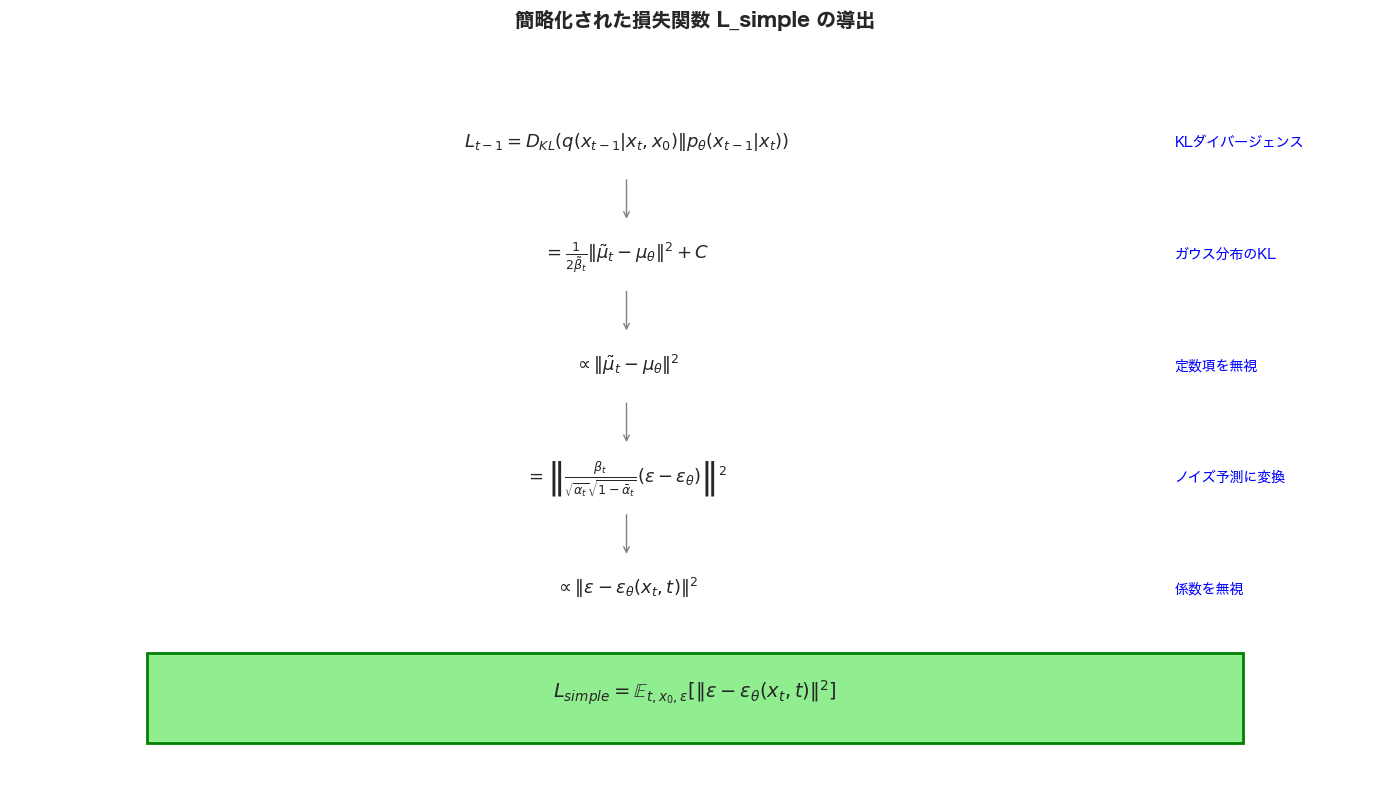

In [8]:
# ============================================================
# L_simple の導出を図示
# ============================================================

fig, ax = plt.subplots(figsize=(14, 8))

derivation = [
    (r'$L_{t-1} = D_{KL}(q(x_{t-1}|x_t, x_0) \| p_\theta(x_{t-1}|x_t))$', 'KLダイバージェンス'),
    (r'$= \frac{1}{2\tilde{\beta}_t} \|\tilde{\mu}_t - \mu_\theta\|^2 + C$', 'ガウス分布のKL'),
    (r'$\propto \|\tilde{\mu}_t - \mu_\theta\|^2$', '定数項を無視'),
    (r'$= \left\| \frac{\beta_t}{\sqrt{\alpha_t}\sqrt{1-\bar{\alpha}_t}} (\epsilon - \epsilon_\theta) \right\|^2$', 'ノイズ予測に変換'),
    (r'$\propto \|\epsilon - \epsilon_\theta(x_t, t)\|^2$', '係数を無視'),
]

y_positions = np.linspace(0.85, 0.25, len(derivation))

for y, (eq, label) in zip(y_positions, derivation):
    ax.text(0.45, y, eq, ha='center', fontsize=13, transform=ax.transAxes)
    ax.text(0.85, y, label, ha='left', fontsize=10, color='blue', transform=ax.transAxes)

for i in range(len(y_positions) - 1):
    ax.annotate('', xy=(0.45, y_positions[i+1] + 0.05), xytext=(0.45, y_positions[i] - 0.04),
                arrowprops=dict(arrowstyle='->', color='gray', lw=1),
                xycoords='axes fraction', textcoords='axes fraction')

# 最終結果
ax.add_patch(plt.Rectangle((0.1, 0.05), 0.8, 0.12, transform=ax.transAxes,
                           facecolor='lightgreen', edgecolor='green', lw=2))
ax.text(0.5, 0.11, r'$L_{simple} = \mathbb{E}_{t,x_0,\epsilon}[\|\epsilon - \epsilon_\theta(x_t, t)\|^2]$', 
        ha='center', fontsize=14, fontweight='bold', transform=ax.transAxes)

ax.set_title('簡略化された損失関数 L_simple の導出', fontsize=14, fontweight='bold')
ax.axis('off')

plt.tight_layout()
plt.show()

In [9]:
# ============================================================
# 訓練アルゴリズムの疑似コード
# ============================================================

print("="*60)
print("DDPM訓練アルゴリズム")
print("="*60)

algorithm = """
Algorithm: DDPM Training

Input: データセット {x₀}, ノイズスケジュール {β_t}, モデル ε_θ

repeat:
    # 1. データをサンプル
    x₀ ~ p_data(x)
    
    # 2. タイムステップをサンプル
    t ~ Uniform({1, ..., T})
    
    # 3. ノイズをサンプル
    ε ~ N(0, I)
    
    # 4. ノイズを加えた画像を計算
    x_t = √ᾱ_t · x₀ + √(1-ᾱ_t) · ε
    
    # 5. 損失を計算
    L = ||ε - ε_θ(x_t, t)||²
    
    # 6. 勾配降下でパラメータを更新
    θ ← θ - η∇_θ L

until 収束
"""

print(algorithm)

DDPM訓練アルゴリズム

Algorithm: DDPM Training

Input: データセット {x₀}, ノイズスケジュール {β_t}, モデル ε_θ

repeat:
    # 1. データをサンプル
    x₀ ~ p_data(x)

    # 2. タイムステップをサンプル
    t ~ Uniform({1, ..., T})

    # 3. ノイズをサンプル
    ε ~ N(0, I)

    # 4. ノイズを加えた画像を計算
    x_t = √ᾱ_t · x₀ + √(1-ᾱ_t) · ε

    # 5. 損失を計算
    L = ||ε - ε_θ(x_t, t)||²

    # 6. 勾配降下でパラメータを更新
    θ ← θ - η∇_θ L

until 収束



In [10]:
# ============================================================
# サンプリングアルゴリズムの疑似コード
# ============================================================

print("="*60)
print("DDPMサンプリングアルゴリズム")
print("="*60)

algorithm = """
Algorithm: DDPM Sampling

Input: 学習済みモデル ε_θ, ノイズスケジュール {β_t}

# 1. 純粋なノイズからスタート
x_T ~ N(0, I)

# 2. 逆方向にイテレート
for t = T, T-1, ..., 1:
    # ノイズ（最後のステップ以外）
    z ~ N(0, I) if t > 1 else z = 0
    
    # ノイズを予測
    ε_pred = ε_θ(x_t, t)
    
    # x_{t-1} を計算
    x_{t-1} = (1/√α_t)(x_t - (β_t/√(1-ᾱ_t))·ε_pred) + σ_t·z

return x₀
"""

print(algorithm)

DDPMサンプリングアルゴリズム

Algorithm: DDPM Sampling

Input: 学習済みモデル ε_θ, ノイズスケジュール {β_t}

# 1. 純粋なノイズからスタート
x_T ~ N(0, I)

# 2. 逆方向にイテレート
for t = T, T-1, ..., 1:
    # ノイズ（最後のステップ以外）
    z ~ N(0, I) if t > 1 else z = 0

    # ノイズを予測
    ε_pred = ε_θ(x_t, t)

    # x_{t-1} を計算
    x_{t-1} = (1/√α_t)(x_t - (β_t/√(1-ᾱ_t))·ε_pred) + σ_t·z

return x₀



---

## 7. 各損失項の重み付け

実際には、$L_{\text{simple}}$ では各タイムステップに等しい重みがかかります。しかし、元のELBOでは各項に異なる重みがあります。

### 📊 重み付きの損失

$$L_{\text{vlb}} = \mathbb{E}_{t, x_0, \epsilon} \left[ \frac{\beta_t^2}{2\sigma_t^2 \alpha_t (1-\bar{\alpha}_t)} \|\epsilon - \epsilon_\theta(x_t, t)\|^2 \right]$$

### 📊 実践では

- $L_{\text{simple}}$（等重み）の方が実践的に良い結果を与えることが多い
- 低いタイムステップでの損失を重視しすぎると不安定になる

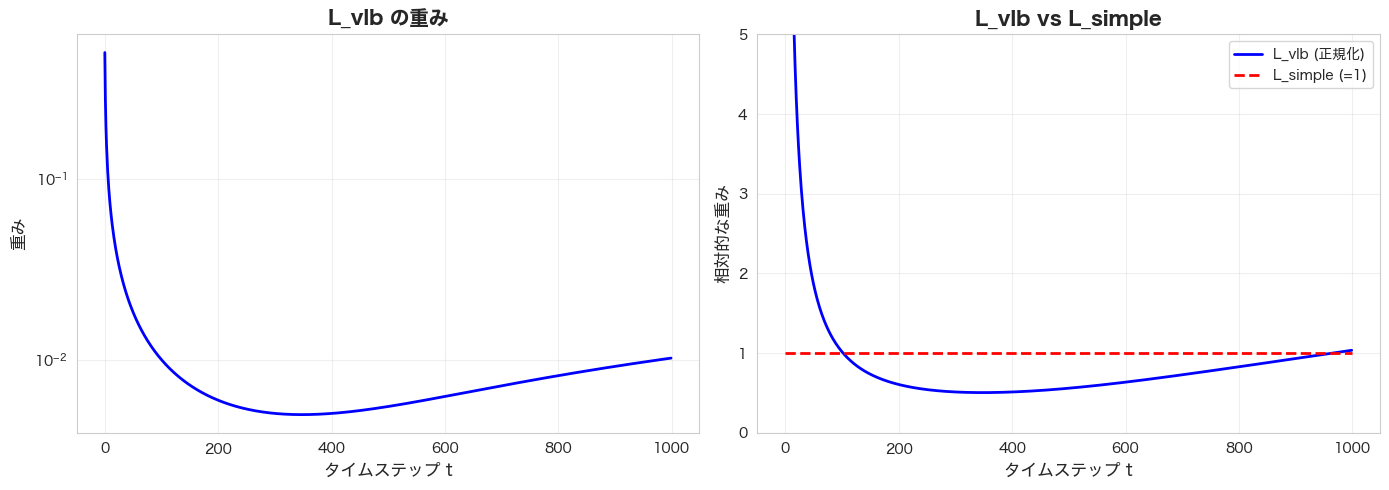

💡 L_vlb では初期のタイムステップ（t≈0）での重みが非常に大きい
   L_simple は全タイムステップを等しく扱う


In [11]:
# ============================================================
# 損失の重みの可視化
# ============================================================

# ELBO重み
sigma_sq = betas  # 簡略化: σ² = β
weights_vlb = betas ** 2 / (2 * sigma_sq * alphas * (1 - alpha_bars))

# Simple重み（すべて1）
weights_simple = torch.ones_like(betas)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
ax.plot(weights_vlb.numpy(), 'b-', linewidth=2, label='L_vlb')
ax.set_xlabel('タイムステップ t', fontsize=12)
ax.set_ylabel('重み', fontsize=12)
ax.set_title('L_vlb の重み', fontsize=14, fontweight='bold')
ax.set_yscale('log')
ax.grid(True, alpha=0.3)

ax = axes[1]
ax.plot(weights_vlb.numpy() / weights_vlb.mean().item(), 'b-', linewidth=2, label='L_vlb (正規化)')
ax.plot(weights_simple.numpy(), 'r--', linewidth=2, label='L_simple (=1)')
ax.set_xlabel('タイムステップ t', fontsize=12)
ax.set_ylabel('相対的な重み', fontsize=12)
ax.set_title('L_vlb vs L_simple', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 5)

plt.tight_layout()
plt.show()

print("💡 L_vlb では初期のタイムステップ（t≈0）での重みが非常に大きい")
print("   L_simple は全タイムステップを等しく扱う")

---

## まとめ

### 🎯 このノートブックで学んだこと

**ELBOの導出**
- ✓ 対数尤度の下界としてのELBO
- ✓ 3種類の項への分解（再構成、事前分布、デノイジング）

**閉形式の式**
- ✓ $q(x_t | x_0) = \mathcal{N}(\sqrt{\bar{\alpha}_t} x_0, (1-\bar{\alpha}_t) I)$
- ✓ $q(x_{t-1} | x_t, x_0)$ の導出

**損失関数**
- ✓ KLダイバージェンスからノイズ予測への変換
- ✓ $L_{\text{simple}} = \|\epsilon - \epsilon_\theta(x_t, t)\|^2$

### 📊 重要な式のまとめ

| 式 | 説明 |
|---|------|
| $x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1-\bar{\alpha}_t} \epsilon$ | ノイズ追加 |
| $\tilde{\mu}_t = \frac{1}{\sqrt{\alpha_t}}(x_t - \frac{\beta_t}{\sqrt{1-\bar{\alpha}_t}} \epsilon)$ | 事後平均 |
| $L = \|\epsilon - \epsilon_\theta(x_t, t)\|^2$ | 損失関数 |

---

## 🎓 自己評価クイズ

### Q1: なぜ $q(x_t | x_0)$ の閉形式が訓練に重要ですか？

<details>
<summary>💡 答えを見る</summary>

**答え**:
- 任意のタイムステップ $t$ での $x_t$ を1回の計算で得られる
- 逐次的にノイズを追加する必要がない
- ランダムな $t$ をサンプルして効率的に訓練できる

</details>

---

### Q2: $q(x_{t-1} | x_t, x_0)$ はなぜ $x_0$ に条件付けられていますか？

<details>
<summary>💡 答えを見る</summary>

**答え**:
- ELBOのデノイジング項で、$q(x_{t-1} | x_t, x_0)$ と $p_\theta(x_{t-1} | x_t)$ のKLを計算するため
- 訓練時には $x_0$ が既知なので、真の事後分布を計算できる
- サンプリング時には $x_0$ を予測する必要がある（だからノイズ予測）

</details>

---

### Q3: $L_{\text{simple}}$ と $L_{\text{vlb}}$ の違いは何ですか？

<details>
<summary>💡 答えを見る</summary>

**答え**:
- $L_{\text{vlb}}$: 理論的に正しいELBOから導かれた重み付き損失
- $L_{\text{simple}}$: 全タイムステップを等しく扱う簡略化された損失
- $L_{\text{simple}}$ の方が実践的に良い結果を与えることが多い
- 初期タイムステップの過度な重みづけを避けられる

</details>

---

### ✅ 学習チェックリスト

- [ ] ELBOを3つの項に分解できる
- [ ] $q(x_t | x_0)$ の閉形式を導出できる
- [ ] $q(x_{t-1} | x_t, x_0)$ のパラメータを説明できる
- [ ] ノイズ予測への変換を説明できる
- [ ] $L_{\text{simple}}$ の式を書ける

---

**次のステップ**: Notebook 39で、**U-Netと位置エンコーディング**を学びます！

ノイズ予測ネットワーク $\epsilon_\theta$ のアーキテクチャを実装します。